In [20]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms.v2 as T
import tqdm
import wandb
import cv2
import skdim
import torchvision

import imageio.v3 as iio

sys.path.insert(0, os.path.abspath("python_packages"))
from python_packages import *
from src import *


train_transform = T.Compose([T.ToImage(), T.ToDtype(torch.float32, scale=True), T.Normalize(mean=[781.0543, 781.0543, 781.0543],std=[1537.8235, 1537.8235, 1537.8235]),T.RandomHorizontalFlip(p=0.5),T.RandomVerticalFlip(p=0.5)])
transform = T.Compose([T.ToImage(),T.ToDtype(torch.float32, scale=True),T.Normalize(mean=[781.0543, 781.0543, 781.0543],std=[1537.8235, 1537.8235, 1537.8235],),])


# Getting inner features and predictions for test dataset with trained Two views one branch model

In [22]:
#api = wandb.Api()
#artifact = api.artifact('hzavadil98/Two_view_one_branch_model/model-q3vgirao:v12', type='model')
#artifact_dir = artifact.download()
#artifact = api.artifact('hzavadil98/Two_view_one_branch_model/model-voscnvyk:v34', type='model')
#artifact_dir = artifact.download()

#model = Two_view_model(num_class=5)
model =Two_view_model.load_from_checkpoint('artifacts/model-q3vgirao:v12/model.ckpt')
model_dens = Two_view_model.load_from_checkpoint('artifacts/model-voscnvyk:v34/model.ckpt')

breast_loader = Breast_Cancer_Dataloader(
    root_folder='/Users/jazav7774/Data/Mammo/',
    annotation_csv="modified_breast-level_annotations.csv",
    imagefolder_path="New_512",
    image_format="dicom",
    norm_kind="dataset_zscore",
    batch_size=16,
    num_workers=8,
)
test_loader = breast_loader.test_dataloader()

In [23]:
def get_featurized_data(dataloader, model, model1):
    """
    Get the full featurized dataset from a dataloader.
    """
    model.to('mps')
    model.eval()
    model_dens.to('mps')
    model_dens.eval()
    with torch.no_grad():
        all_in_features = []
        all_in_features1 = []
        all_512_features = []
        all_512_features1 = []
        all_labels = []
        all_labels1 = []
        all_logits = []
        all_logits1 = []
        for batch in tqdm.tqdm(dataloader, desc="Featurizing dataset"):
            x, y1, y2 = batch
            #y = y1 if model.task == 1 else y2
            x = [item.to('mps') for item in x]
            y1.to('mps')
            y2.to('mps')
            all_labels.append(y1)
            all_labels1. append(y2)
            
            x1 = [model.resnets[i].resnet(image) for i, image in enumerate(x)]
            x2 = [model.resnets[i](image) for i, image in enumerate(x)]
            
            x3 = [model1.resnets[i].resnet(image) for i, image in enumerate(x)]
            x4 = [model1.resnets[i](image) for i, image in enumerate(x)]

            all_in_features.append(torch.cat(x2, dim=1))
            all_512_features.append(torch.cat(x1, dim=1))
            
            all_in_features1.append(torch.cat(x4, dim = 1))
            all_512_features1.append(torch.cat(x3, dim=1))
            
            y_hat = model.fc(torch.cat(x2, dim=1))
            y_hat1 = model1.fc(torch.cat(x4, dim=1))
            all_logits.append(y_hat)
            all_logits1.append(y_hat1)
        all_in_features = torch.cat(all_in_features, dim=0).cpu().numpy()
        all_in_features1 = torch.cat(all_in_features1, dim=0).cpu().numpy()
        all_512_features = torch.cat(all_512_features, dim=0).cpu().numpy()
        all_512_features1 = torch.cat(all_512_features1, dim=0).cpu().numpy()
        all_logits = torch.cat(all_logits, dim=0).cpu().numpy()
        all_logits1 = torch.cat(all_logits1, dim=0).cpu().numpy()
        all_labels = torch.cat(all_labels, dim=0).cpu().numpy()
        all_labels1 = torch.cat(all_labels1, dim=0).cpu().numpy()

    return all_512_features, all_in_features, all_logits, all_labels, all_512_features1, all_in_features1, all_logits1, all_labels1 

cancer_512_features, cancer_in_features, cancer_logits, cancer_labels, dens_512_features, dens_in_features, dens_logits, dens_labels = get_featurized_data(test_loader, model, model_dens)


Featurizing dataset: 100%|██████████| 125/125 [04:54<00:00,  2.35s/it]


In [24]:
cancer_512_features.shape
#cancer_logits.shape
#cancer_predictions = np.argmax(cancer_logits, axis=1)
#cancer_labels.shape

(2000, 1024)

In [ ]:
#sorted_indices = np.argsort(cancer_labels)

# Reorder each array in data_r based on the sorted indices
#cancer_in_features = cancer_in_features[sorted_indices, :]
#cancer_predictions = cancer_predictions[sorted_indices]
#cancer_labels = cancer_labels[sorted_indices]
#cancer_512_features = cancer_512_features[sorted_indices, :]
# Print the bincount of the first 100 labels to verify the grouping
#print(np.bincount(cancer_labels[sorted_indices]))

[1341  467   93   76   23]


# AJIVE Analysis of the two inner blocks

Text(0.5, 1.0, 'PCA on the second view')

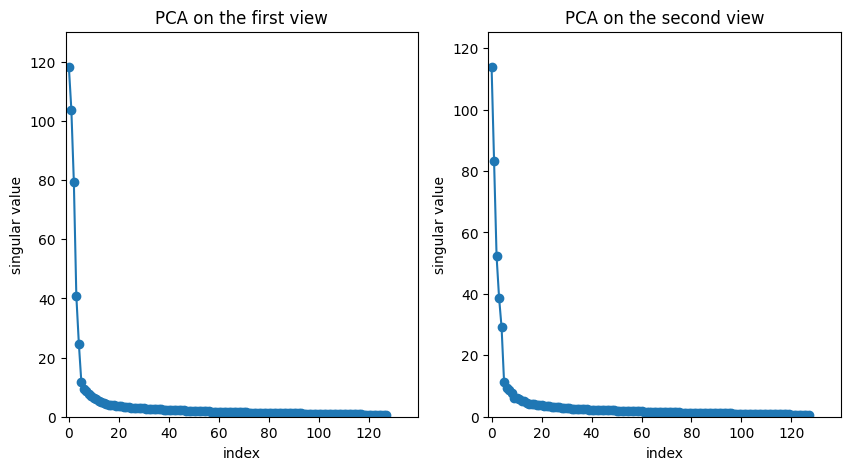

In [25]:
plt.figure(figsize=[10, 5])
plt.subplot(1, 2, 1)
PCA().fit(cancer_in_features[:,:128]).plot_scree(log = False)
plt.title("PCA on the first view")
plt.subplot(1, 2, 2)
PCA().fit(cancer_in_features[:,128:]).plot_scree(log = False)
plt.title("PCA on the second view")

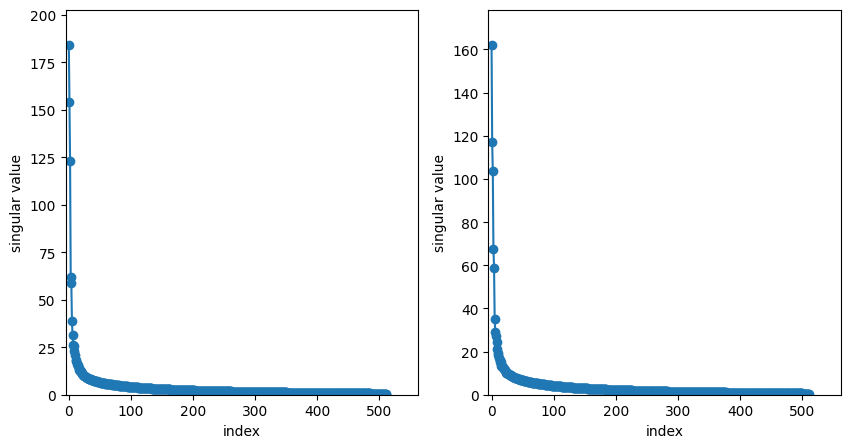

In [26]:
plt.figure(figsize=[10, 5])
plt.subplot(1, 2, 1)
PCA().fit(cancer_512_features[:,:512]).plot_scree(log = False)
plt.subplot(1, 2, 2)
PCA().fit(cancer_512_features[:,512:]).plot_scree(log = False)

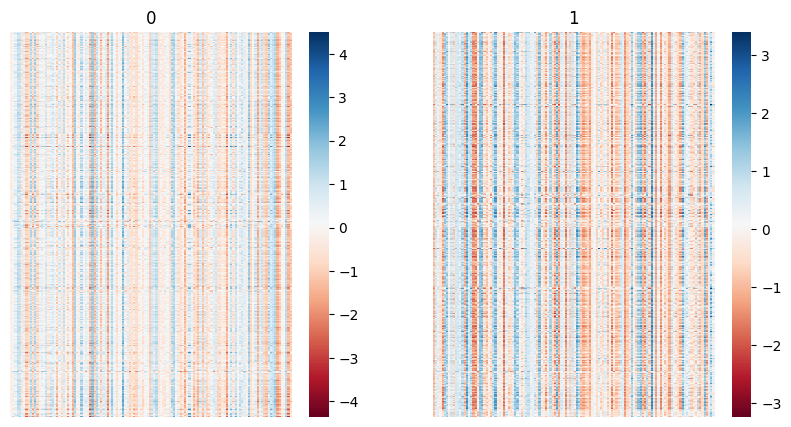

In [27]:
plt.figure(figsize=[10, 5])
data_block_heatmaps([cancer_in_features[:,:128], cancer_in_features[:,128:]])

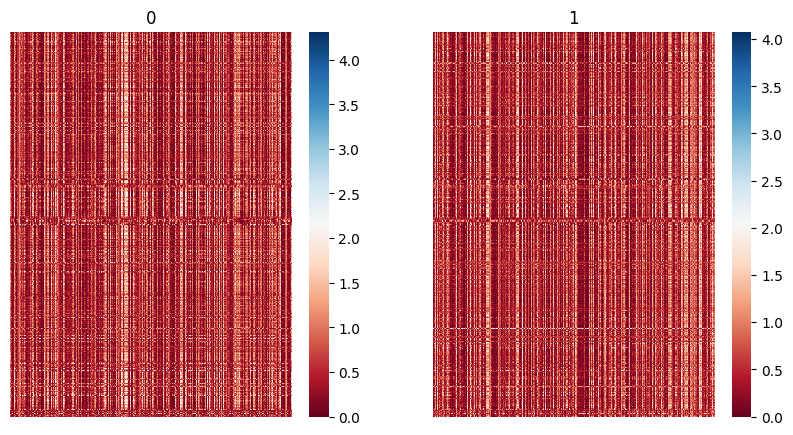

In [28]:
plt.figure(figsize=[10, 5])
data_block_heatmaps([cancer_512_features[:,:512], cancer_512_features[:,512:]])


In [29]:
pca=skdim.id.lPCA()
gID1 = pca.fit(cancer_in_features[:,:128]).dimension_
gID2 = pca.fit(cancer_in_features[:,128:]).dimension_
print(f'pca ID estimation: {gID1},{gID2}')
est = skdim.id.DANCo()
gID1 = est.fit(cancer_in_features[:,:128]).dimension_
gID2 = est.fit(cancer_in_features[:,128:]).dimension_
print(f'DANCo ID estimation: {gID1},{gID2}')


pca ID estimation: 4,5
DANCo ID estimation: 9.974229549693579,10.975138911093348


In [30]:
est = skdim.id.CorrInt()
gID1 = est.fit(cancer_in_features[:,:128]).dimension_
gID2 = est.fit(cancer_in_features[:,128:]).dimension_
print(f'CorrInt ID estimation: {gID1},{gID2}')
est = skdim.id.ESS()
gID1 = est.fit(cancer_in_features[:,:128]).dimension_
gID2 = est.fit(cancer_in_features[:,128:]).dimension_
print(f'ESS ID estimation: {gID1},{gID2}')

CorrInt ID estimation: 5.356958782543448,5.797579766045512
ESS ID estimation: 5.968401717648698,6.901436925938128


In [31]:
aj = AJIVE(init_signal_ranks=[10,10], n_jobs=16, center=True)
aj.fit([cancer_in_features[:,:128], cancer_in_features[:,128:]])
aj.summary()

'AJIVE, joint rank: 4, view 0 indiv rank: 8, view 1 indiv rank: 8'

In [32]:
aj512 = AJIVE(init_signal_ranks=[12,12], n_jobs=16, center=False)
aj512.fit([cancer_512_features[:,:512], cancer_512_features[:,512:]])
aj512.summary()


'AJIVE, joint rank: 2, view 0 indiv rank: 10, view 1 indiv rank: 10'

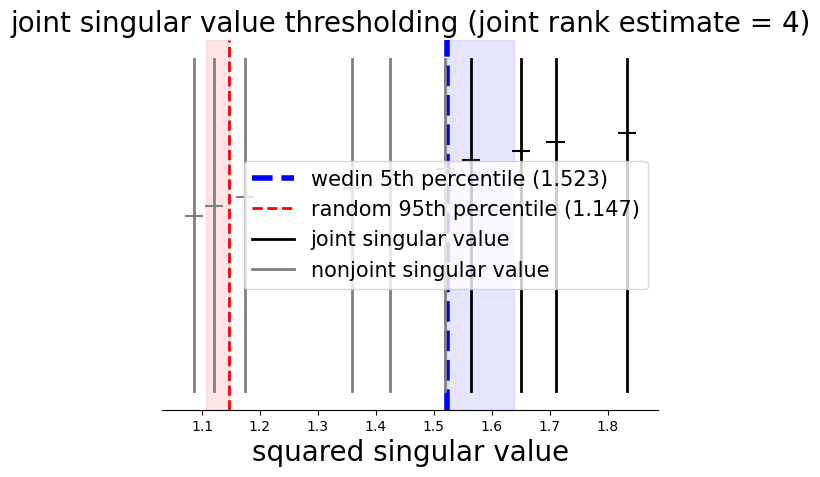

In [33]:
aj.plot_joint_diagnostic()

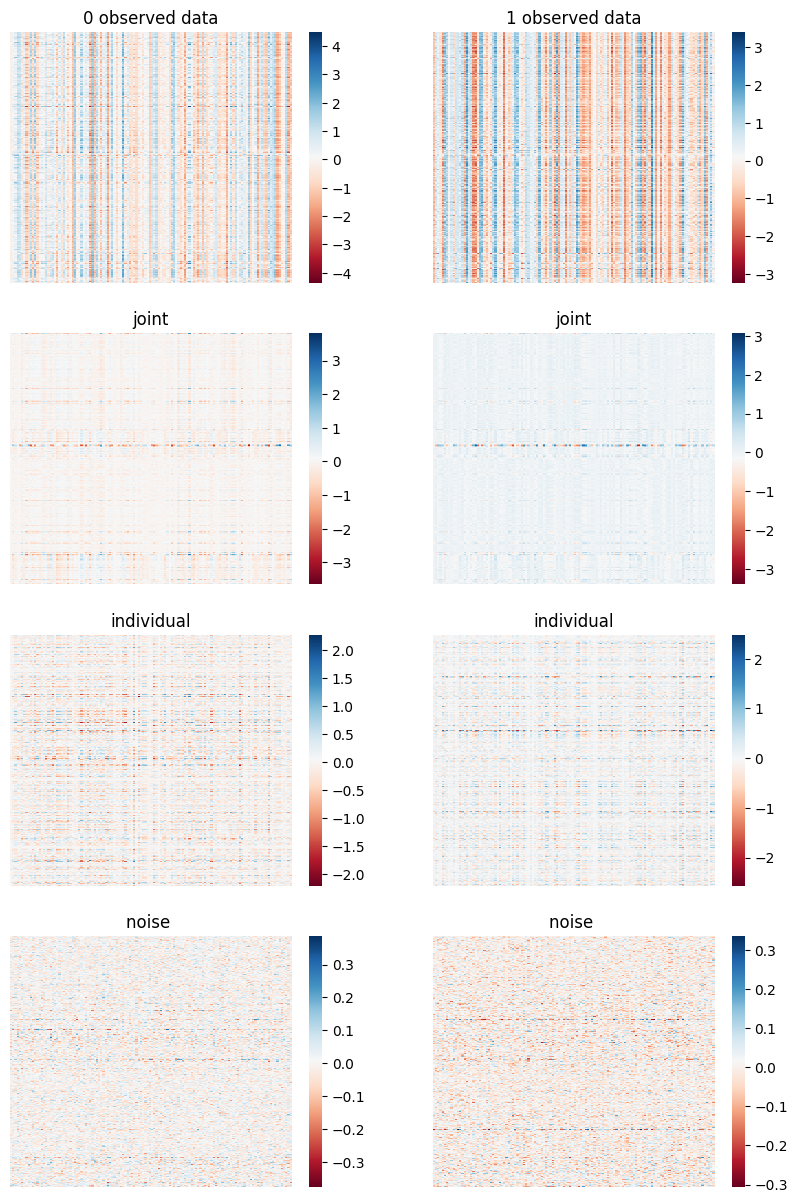

In [34]:
plt.figure(figsize=[10, 15])
jive_full_estimate_heatmaps(aj.get_view_decomps(),blocks=[cancer_in_features[:,:128], cancer_in_features[:,128:]])


In [35]:
aj.get_ranks()
centerer = aj.view_specific_[0].individual_.centerer_


In [36]:
aj.common_.transform([cancer_in_features[:,:128], cancer_in_features[:,128:]]).shape
aj.common_.views_[0].view_loadings_.shape

(128, 4)

In [37]:
aj.view_specific_[0].individual_.transform(cancer_in_features[:,:128]).shape

(2000, 8)

In [38]:
a11 = aj.view_specific_[0].joint_.transform(cancer_in_features[:,:128])
a12 = aj.view_specific_[1].joint_.transform(cancer_in_features[:,128:])
#a1 = aj.common_.transform([aji[0]['joint'], aji[1]['joint']])
a2 = aj.common_.transform([cancer_in_features[:,:128], cancer_in_features[:,128:]])
aj.view_specific_[0].joint_.loadings_.shape
#a1 = a11 + a12
#np.mean(a1)
#aj.view_specific_[0].joint_.loadings_


(128, 4)

In [39]:
aji = aj.get_view_decomps()
J = aji[0]['joint']
I = aji[0]['individual']
N = aji[0]['noise']
comb =  J + I + N
comb = centerer.inverse_transform(comb)
sum(sum(np.abs(comb - cancer_in_features[:,:128])))/256000

np.float32(1.2872592e-09)

In [40]:
A = cancer_in_features[:,:128]
B = aji[0]['joint']

T = aj.common_.common_norm_scores_
T1 = np.dot(T, T.T)
np.dot(T, np.dot(T.T, A)) - B

T = aj.common_.views_[0].view_loadings_
T1 = np.dot(T, T.T)
np.dot(A, T1)-B
#np.dot(T1, A) - B
#centerer = aj.common_.views_[0].centerer_
#centerer.inverse_transform(r)-B
#aj.common_.common_loadings_[0].shape



array([[-0.00926853, -0.04878045, -0.0397743 , ..., -0.01728326,
        -0.01708432,  0.07168788],
       [ 0.11767948, -0.1285516 ,  0.15345314, ...,  0.10695526,
        -0.22423759,  0.4124424 ],
       [-0.28106028,  0.6056887 , -0.55061424, ..., -0.545314  ,
         1.167423  , -1.0946062 ],
       ...,
       [-0.21723159,  0.95532185, -0.18810922, ..., -0.41560468,
         1.5424447 , -0.7413073 ],
       [-0.02948256, -0.0708802 ,  0.0842658 , ...,  0.11591128,
        -0.15349999,  0.10649175],
       [-0.02654775, -0.09722783, -0.10416845, ..., -0.0416569 ,
        -0.06643736, -0.00856747]], dtype=float32)

# Assesing classification on different representations of data

In [42]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import balanced_accuracy_score, f1_score
from imblearn.over_sampling import SMOTE

# Cross-validation with KNN
def cross_val_knn(X, y, n_neighbors=5, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    results = []

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Handle class imbalance using SMOTE
        smote = SMOTE()
        X_train, y_train = smote.fit_resample(X_train, y_train)

        # Apply KNN classifier
        knn = KNeighborsClassifier(n_neighbors=n_neighbors)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)

        # Calculate balanced accuracy score
        acc = f1_score(y_test, y_pred, average='macro')   
        results.append(acc)
    
    return np.mean(results)


In [43]:
X0 = cancer_in_features
X1 = cancer_in_features[:,:128]
X2 = cancer_in_features[:,128:]
X3 = aj.common_.transform([X1, X2])
X4 = np.concat((aj.view_specific_[0].joint_.transform(X1), aj.view_specific_[1].joint_.transform(X2)), axis=1)
X5 = aj.view_specific_[0].joint_.transform(X1)
X6 = aj.view_specific_[1].joint_.transform(X2)
X7 = np.concat((aj.view_specific_[0].individual_.transform(X1), aj.view_specific_[1].individual_.transform(X2)), axis=1)
X8 = np.concat((X4, X7), axis=1)
data = ['both views','CC view', 'MLO view', 'Common Joint 3 dim', 'Ajive Joint', 'AJIVE CC joint', 'AJIVE MLO joint', 'AJIVE both individual', 'AJIVE joint + individual']
y = cancer_labels


In [44]:
n_neigh = 10
res0 = cross_val_knn(X0, y, n_neighbors=n_neigh, n_splits=5)
res1 = cross_val_knn(X1, y, n_neighbors=n_neigh, n_splits=5)
res2  = cross_val_knn(X2, y, n_neighbors=n_neigh, n_splits=5)
res3  = cross_val_knn(X3, y, n_neighbors=n_neigh, n_splits=5)
res4  = cross_val_knn(X4, y, n_neighbors=n_neigh, n_splits=5)
res5  = cross_val_knn(X5, y, n_neighbors=n_neigh, n_splits=5)
res6  = cross_val_knn(X6, y, n_neighbors=n_neigh, n_splits=5)
res7  = cross_val_knn(X7, y, n_neighbors=n_neigh, n_splits=5)
res8  = cross_val_knn(X8, y, n_neighbors=n_neigh, n_splits=5)
for i, res in enumerate([res0, res1, res2, res3, res4, res5, res6, res7, res8]):
    print(f'Balanced accuracy for {data[i]}: {res}')


Balanced accuracy for both views: 0.3344868830647837
Balanced accuracy for CC view: 0.28643285885048614
Balanced accuracy for MLO view: 0.3048060587540181
Balanced accuracy for Common Joint 3 dim: 0.3504912829472483
Balanced accuracy for Ajive Joint: 0.3548470425879191
Balanced accuracy for AJIVE CC joint: 0.3154778219676989
Balanced accuracy for AJIVE MLO joint: 0.306457072140833
Balanced accuracy for AJIVE both individual: 0.3431555143686533
Balanced accuracy for AJIVE joint + individual: 0.3392677018117949


# Figuring out how to saliency map

In [64]:
cancer_predictions = np.argmax(cancer_logits, axis=1)

In [65]:
def saliency_map(model, x, plot=True):
    """
    Computes the saliency map of an input sample with respect to the predicted class. 
    
    Parameters:
        model (torch.nn.Module): Trained model.
        x (list): List of input samples from Breast_Cancer_Dataloader.
        plot (bool): Whether to plot the saliency map. 
        
    Returns:
        saliency (list): List of saliency maps.
        target_class (int): Predict
    """
    x = [item.to('mps') for item in x]
    model.to('mps')
    for i in range(2):
        x[i] = x[i].unsqueeze(0)
        x[i].requires_grad = True

    output = model(x)
    target_class = output.argmax(dim=1)

    model.zero_grad()
    output[0, target_class].backward()
    saliency = [sample.grad.abs().max(dim=1)[0].squeeze().cpu().numpy() for sample in x]
    
    if plot:
        fig, axs = plt.subplots(2, 2)
        for i in range(2):
            axs[0, i].imshow(x[i].cpu().detach().numpy()[0,0,:,:], cmap='gray')
            axs[0, i].set_title(f'view: {'CC' if i == 0 else 'MLO'}')
            axs[0, i].axis('off')
            axs[1, i].imshow(saliency[i], cmap='hot')
            axs[1, i].set_title(f"y=: , y_hat: {target_class.item()}")
            axs[1, i].axis('off')

    
    return saliency, target_class.item()

def overlay_saliency_on_image(image, saliency, alpha=0.5, colormap=cv2.COLORMAP_JET, plot=True):
    """
    Overlays a saliency map on an image.
    
    Parameters:
        image (np.ndarray/torch.Tensor): Image.
        saliency (np.ndarray/torch.Tensor): Saliency map.
        alpha (float): Transparency of the heatmap (0 = only image, 1 = only heatmap).
        colormap (int): OpenCV colormap (e.g., cv2.COLORMAP_JET).
        plot (bool): Whether to plot the overlayed image.
        
    Returns:
        image (np.ndarray): Original image.
        overlayed_img (np.ndarray): Overlayed image.
    """

    if isinstance(saliency, torch.Tensor):
        saliency = saliency.cpu().detach().numpy()  # Convert PyTorch tensor to NumPy
    if isinstance(image, torch.Tensor):
        image = image.cpu().detach().numpy()  # Convert PyTorch tensor to NumPy
    elif isinstance(image, torchvision.tv_tensors._image.Image):
        image = np.array(image)  # Convert torchvision Image to NumPy

    # Normalize saliency map to range [0, 255]
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())  # Normalize to [0,1]
    saliency = (saliency * 255).astype(np.uint8)  # Scale to [0,255]

    heatmap = saliency
    # Apply a colormap to make the saliency map visually interpretable
    heatmap = cv2.applyColorMap(saliency, colormap)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2GRAY)  # Convert OpenCV BGR to grayscale

    # Convert grayscale image to 3-channel for blending
    if len(image.shape) == 3:  
        image = image[0]
    image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0,1]
    image = (image * 255).astype(np.uint8)
       
    # Blend the heatmap with the original image
    overlayed_img = cv2.addWeighted(image, 1 - alpha, heatmap, alpha, 0)

    if plot:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        plt.title('Image')
        plt.subplot(1, 2, 2)
        plt.imshow(overlayed_img, cmap='jet')
        plt.axis('off')
        plt.title('Overlayed Image')
        plt.show()  
    
    return image, overlayed_img

def overlay_saliency_on_pair(model, dataloader, split, idx, alpha=0.5, colormap=cv2.COLORMAP_JET, plot=True):
    """
    Overlays saliency maps on a pair of images from a dataloader.
    
    Parameters:
        model (torch.nn.Module): Trained model.
        dataloader (Breast_Cancer_Dataloader): Breast cancer dataloader.
        split (str): Dataset split ('train', 'val', 'test').
        idx (int): Index of the image pair.
        alpha (float): Transparency of the heatmap (0 = only image, 1 = only heatmap).
        colormap (int): OpenCV colormap (e.g., cv2.COLORMAP_JET).
        plot (bool): Whether to plot the overlayed images.
        
    Returns:
        images (list): List of original images.
        saliencies (list): List of saliency maps.
        overlayed_imgs (list): List of overlayed images.    
    """
    if split == 'train':
        images, y1, y2 = dataloader.train_dataset[idx]
    elif split =='val':
        images, y1, y2 = dataloader.val_dataset[idx]
    elif split == 'test':
        images, y1, y2 = dataloader.test_dataset[idx]
        
    y = y1 if model.task == 1 else y2

    saliencies, y_hat = saliency_map(model, images, plot=False)
    
    results = []
    for image, saliency in zip(images, saliencies):
        results.append(overlay_saliency_on_image(image, saliency, alpha, colormap, plot=False))
    images, overlayed_imgs = zip(*results)
    # plot both overlayed saliency maps next to the original images
    if plot:
        fig, axs = plt.subplots(3, 2, figsize=(10, 15))
        for i in range(2):
            axs[0, i].imshow(images[i], cmap='gray')
            axs[0, i].set_title(f'view: {'CC' if i == 0 else 'MLO'}')
            axs[0, i].axis('off')
            axs[1, i].imshow(saliencies[i], cmap='hot')
            axs[1, i].set_title('pure saliency map')
            axs[1, i].axis('off')
            axs[2, i].imshow(overlayed_imgs[i], cmap='jet')
            axs[2, i].set_title(f"y=: {y}, y_hat: {y_hat}")
            axs[2, i].axis('off')
    return images, saliencies, overlayed_imgs
    


In [66]:
print(np.where(cancer_predictions==4))
print(np.where(cancer_labels==4))
cancer_labels[np.where(cancer_predictions==4)]

(array([ 493,  765,  768,  886,  890,  894,  976,  979,  980,  986, 1211,
       1242, 1542, 1763, 1844, 1964, 1974, 1978, 1984]),)
(array([ 152,  515,  700,  765,  766,  768,  894,  902,  980,  981,  985,
        986,  988, 1123, 1211, 1542, 1763, 1844, 1884, 1889, 1964, 1978,
       1984]),)


array([2, 4, 4, 3, 3, 4, 3, 3, 4, 4, 4, 1, 4, 4, 4, 4, 3, 4, 4])

In [67]:
print(np.where((cancer_predictions==3)&(cancer_labels==0)))

(array([983, 996]),)


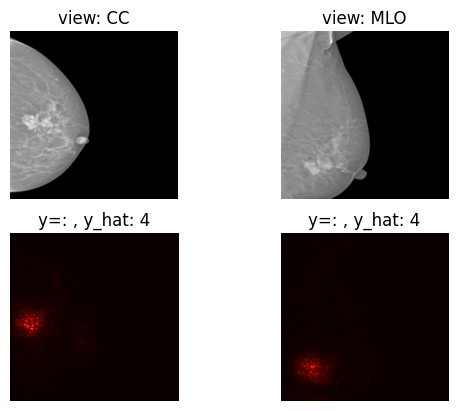

In [68]:
saliency = saliency_map(model, breast_loader.test_dataset[894][0])

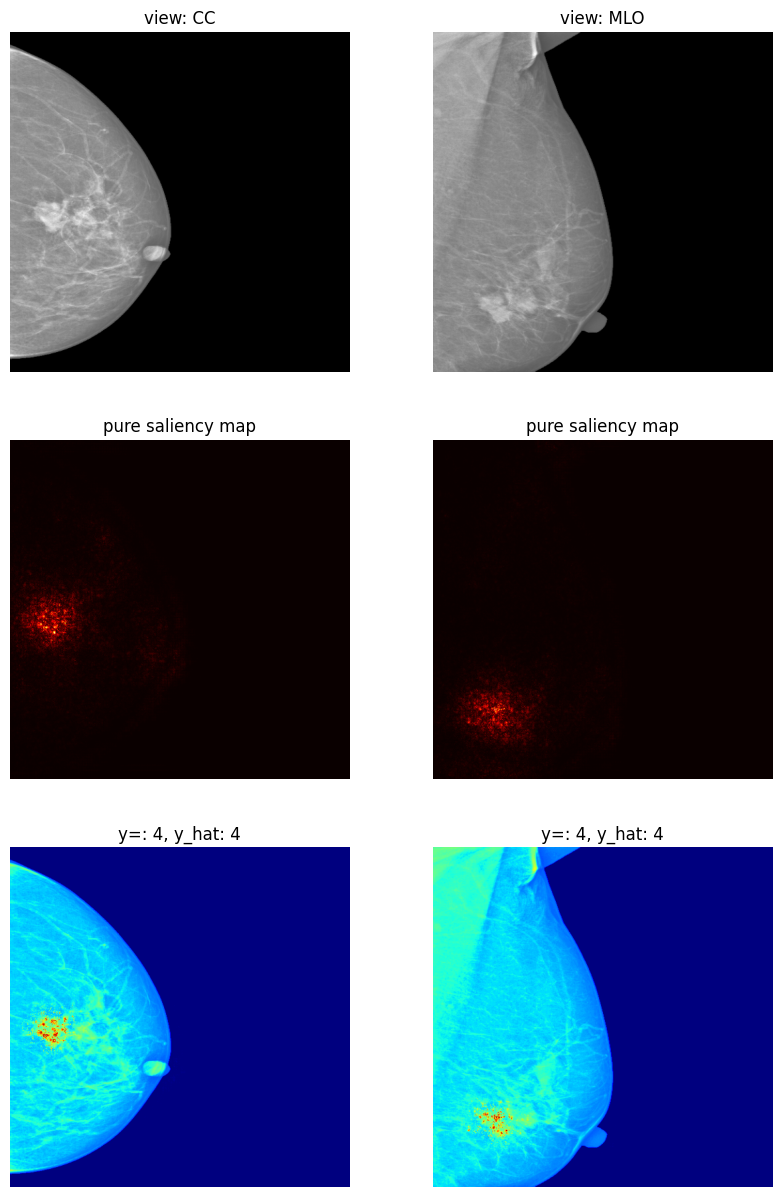

In [69]:
images, saliencies, overlayed_imgs = overlay_saliency_on_pair(model, breast_loader, 'test', 894, alpha=0.5, colormap=cv2.COLORMAP_JET)

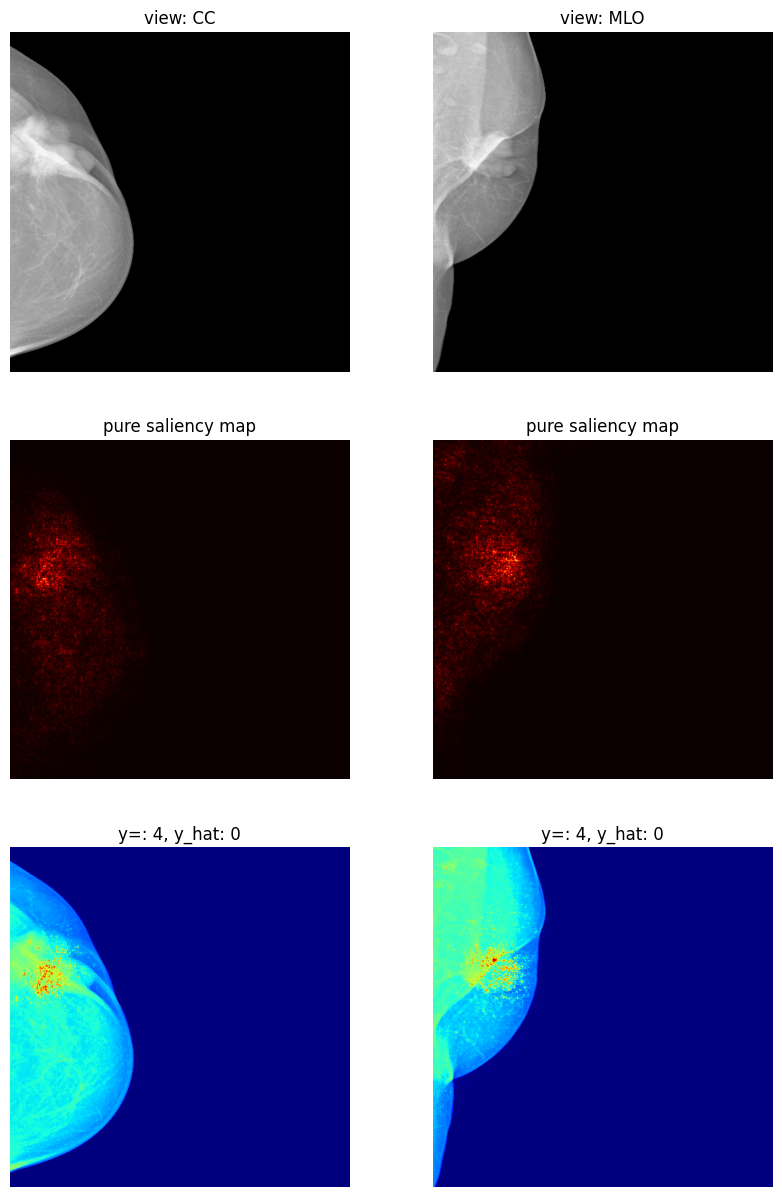

In [70]:
images, saliencies, overlayed_imgs = overlay_saliency_on_pair(model, breast_loader, 'test', 515, alpha=0.5, colormap=cv2.COLORMAP_JET)

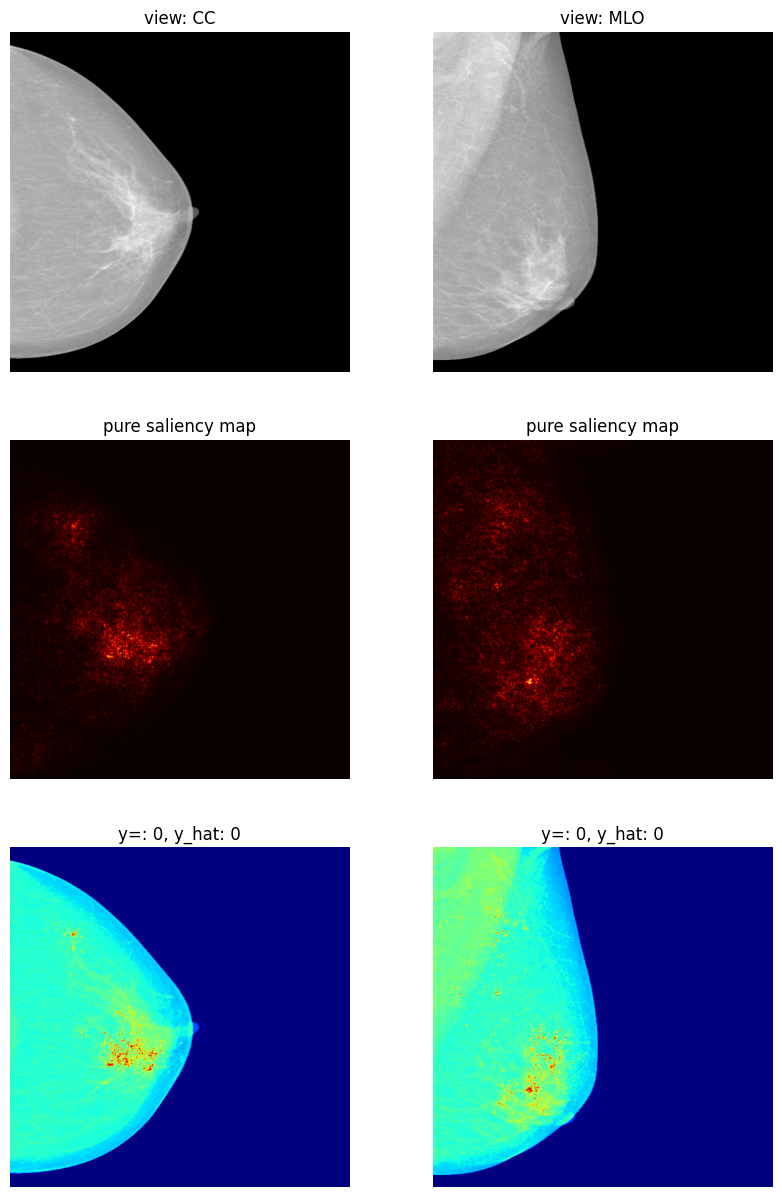

In [71]:
images, saliencies, overlayed_imgs = overlay_saliency_on_pair(model, breast_loader, 'test', 0, alpha=0.5, colormap=cv2.COLORMAP_JET)

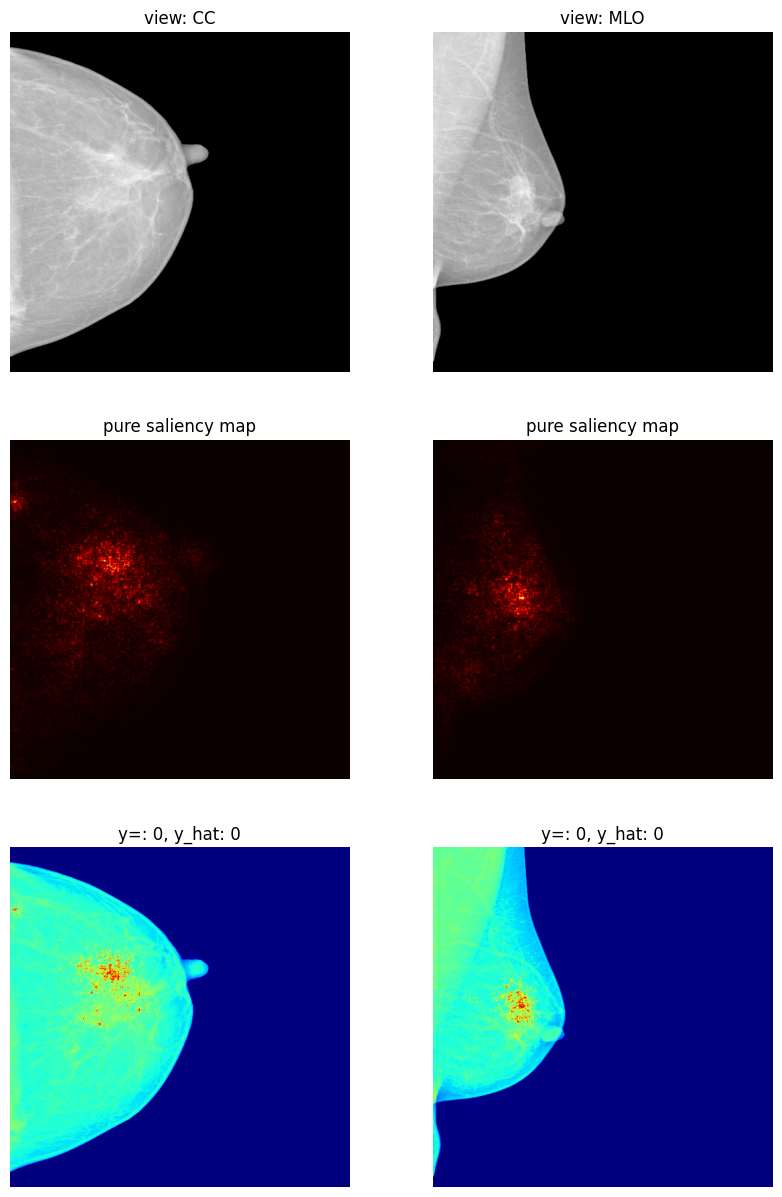

In [72]:
images, saliencies, overlayed_imgs = overlay_saliency_on_pair(model, breast_loader, 'test', 754, alpha=0.5, colormap=cv2.COLORMAP_JET)

# AJIVE - putting cancer vs density models, factorized saliency

Text(0.5, 1.0, 'Scree plot density model')

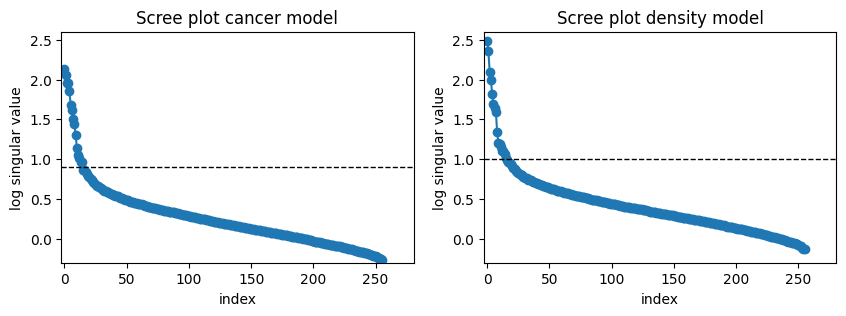

In [73]:
plt.figure(figsize=[10, 3])
plt.subplot(1, 2, 1)
PCA().fit(cancer_in_features).plot_scree(log = True)
plt.axhline(0.9, linestyle = "--", color = "k", linewidth = 1)
plt.ylim((-0.3,2.6))
plt.title("Scree plot cancer model")
plt.subplot(1, 2, 2)
PCA().fit(dens_in_features).plot_scree(log = True)
plt.axhline(1, linestyle = "--", color = "k", linewidth = 1)
plt.ylim((-0.3,2.6))
plt.title("Scree plot density model")

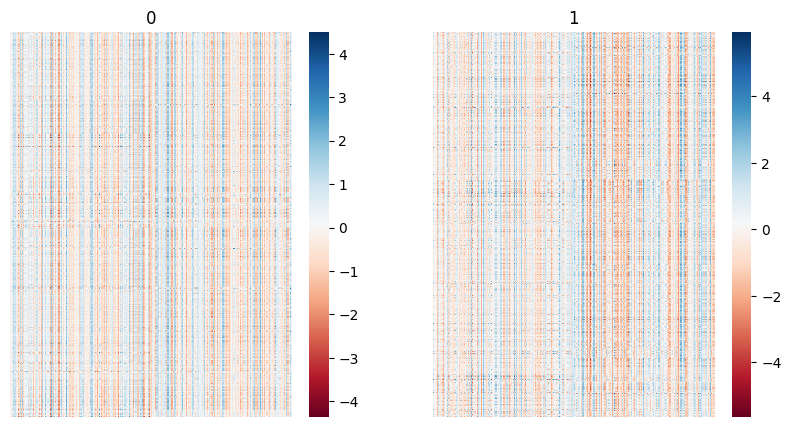

In [74]:
plt.figure(figsize=[10, 5])
data_block_heatmaps([cancer_in_features, dens_in_features])

In [75]:
aj = AJIVE(init_signal_ranks=[15,15], n_jobs=16, center=True)
aj.fit([cancer_in_features, dens_in_features])
aj.summary()

'AJIVE, joint rank: 3, view 0 indiv rank: 12, view 1 indiv rank: 12'

In [76]:
np.argmin(aj.view_specific_[0].joint_.scores_[:,0])

np.int64(1322)

In [77]:
def ajive_saliency_map(model, x_list, common_loading_vector, title = "Saliency map", plot=True):
    """
    Computes the saliency map of an input sample with respect to a given AJIVE common loading vector.
    
    Parameters:
        model (torch.nn.Module): Trained model.
        x_list (list): List of input image tensors (e.g., [(C,H,W), (C,H,W)]) for each view.
                       Each tensor should be for a single sample, without the batch dimension.
        common_loading_vector (np.ndarray): The AJIVE common loading vector (e.g., for concatenated features).
        plot (bool): Whether to plot the saliency map. 
        
    Returns:
        saliency_maps (list): List of saliency maps (np.ndarray) for each view.
    """
    device = next(model.parameters()).device
    model.eval() # Ensure model is in evaluation mode

    x_processed_with_grad = []
    original_images_for_plot = []

    for x_item in x_list:
        # Ensure x_item is on the correct device and has the right shape (1, C, H, W)
        # x_item is expected to be (C,H,W) or (1,H,W) if channel is 1
        img = x_item.clone().detach().to(device)
        original_images_for_plot.append(img.cpu()) # Store for plotting before adding batch dim

        if img.ndim == 2: # (H, W) -> (1, 1, H, W)
            img = img.unsqueeze(0).unsqueeze(0)
        elif img.ndim == 3: # (C, H, W) -> (1, C, H, W)
            img = img.unsqueeze(0)
        elif img.ndim == 4 and img.shape[0] == 1: # Already (1, C, H, W)
            pass
        else:
            raise ValueError(f"Input image tensor has unexpected shape: {x_item.shape}")
        
        img.requires_grad = True
        x_processed_with_grad.append(img)

    # Get intermediate features (output of model.resnexts for each view)
    # These should be [1, 512] for each view after passing through resnexts
    features_v1 = model.resnets[0](x_processed_with_grad[0])
    features_v2 = model.resnets[1](x_processed_with_grad[1])

    # Ensure loading vector is a tensor on the correct device
    loading_vector_tensor = torch.tensor(common_loading_vector, dtype=features_v1.dtype, device=device)
    if loading_vector_tensor.ndim == 1:
        loading_vector_tensor = loading_vector_tensor.unsqueeze(0) # Make it [1, D] if it's [D] for matmul

    expected_feature_dim = features_v1.shape[1] + features_v2.shape[1]
    if loading_vector_tensor.shape[1] != expected_feature_dim: # common_loading_vector is [D], so loading_vector_tensor is [1,D]
        raise ValueError(
            f"Dimension mismatch: loading vector has dimension {loading_vector_tensor.shape[1]}, "
            f"but concatenated features have dimension {expected_feature_dim}."
        )

    concatenated_features = torch.cat((features_v1, features_v2), dim=1)  # Shape: [1, 1024]
    
    # ajive_score = torch.matmul(concatenated_features, loading_vector_tensor.t()) # if loading_vector_tensor is [1,D] -> [1,1]
    ajive_score = torch.sum(concatenated_features * loading_vector_tensor) # Element-wise product and sum for [1,D] and [1,D] -> scalar

    if ajive_score.numel() != 1:
        raise ValueError(f"AJIVE score must be a scalar. Got shape: {ajive_score.shape}")
    
    scalar_ajive_score = ajive_score # It's already scalar after sum

    model.zero_grad()
    # Ensure grads of inputs are zero if they exist from previous ops
    for x_p in x_processed_with_grad:
        if x_p.grad is not None:
            x_p.grad.detach_()
            x_p.grad.zero_()
            
    scalar_ajive_score.backward()

    saliency_maps_list = []
    for x_item_processed in x_processed_with_grad:
        if x_item_processed.grad is None:
            print(f"Warning: Gradient for an input item is None. Returning zero saliency map for this item.")
            h, w = x_item_processed.shape[2], x_item_processed.shape[3] # (1, C, H, W)
            saliency_map_np = np.zeros((h, w), dtype=np.float32)
        else:
            # Grad shape is (1, C, H, W). Max over C -> (1, H, W). Squeeze -> (H, W)
            saliency_map_tensor = x_item_processed.grad.abs().max(dim=1)[0] 
            saliency_map_np = saliency_map_tensor.squeeze().cpu().numpy()
        saliency_maps_list.append(saliency_map_np)
    
    if plot:
        fig, axs = plt.subplots(2, len(x_list), figsize=(4 * len(x_list), 8))
        if len(x_list) == 1: # Ensure axs is 2D array for consistent indexing
            axs = np.array([axs]).T 
        plt.suptitle("Visualisation of cancer prediction model")


        for i in range(len(x_list)):
            # original_images_for_plot[i] is (C,H,W) or (1,H,W)
            img_to_show = original_images_for_plot[i].squeeze().numpy() # Squeeze out channel if 1
            if img_to_show.ndim == 3 and img_to_show.shape[0] > 1 : # (C,H,W) with C > 1
                img_to_show = img_to_show[0] # Show first channel if multi-channel (e.g. RGB)

            axs[0, i].imshow(img_to_show, cmap='gray')
            axs[0, i].set_title(f"View: {"CC" if i == 0 else "MLO"}")
            axs[0, i].axis('off')
            
            axs[1, i].imshow(saliency_maps_list[i], cmap='hot')
            axs[1, i].set_title(title)
            axs[1, i].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    return saliency_maps_list
    

In [78]:
first_common_loading = aj.common_.views_[0].view_loadings_[:, 0]
#first_common_loading = aj.view_specific_[0].joint_.loadings_[:, 0]

first_indiv_loading = aj.view_specific_[0].individual_.loadings_[:,0]


In [79]:
cancer_idxs = np.where(cancer_labels == 4)
print(dens_labels[cancer_idxs])
print(cancer_idxs)

[2 1 2 1 2 2 1 1 2 3 1 2 2 2 2 2 2 2 2 2 2 2 1]
(array([ 152,  515,  700,  765,  766,  768,  894,  902,  980,  981,  985,
        986,  988, 1123, 1211, 1542, 1763, 1844, 1884, 1889, 1964, 1978,
       1984]),)


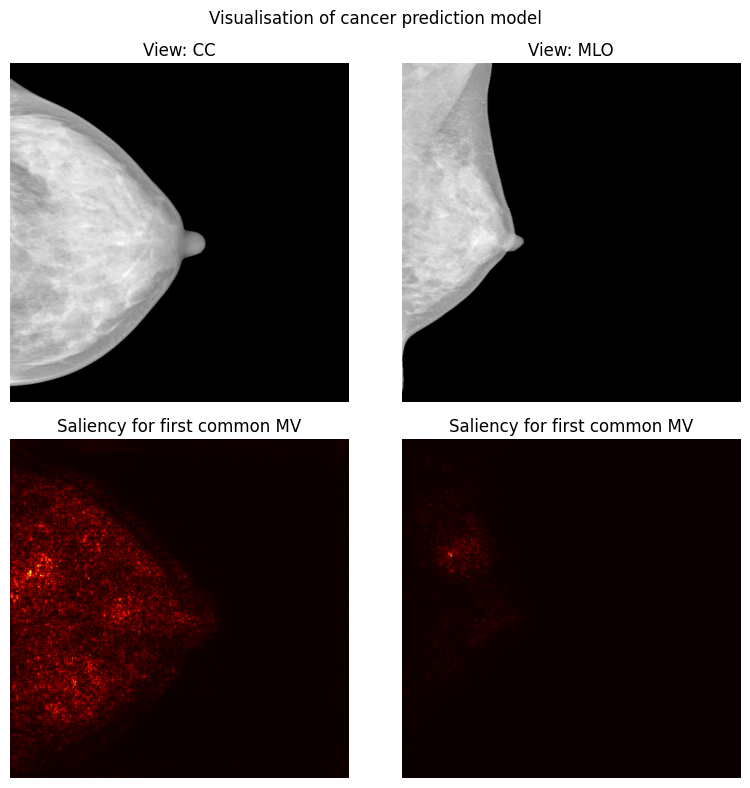

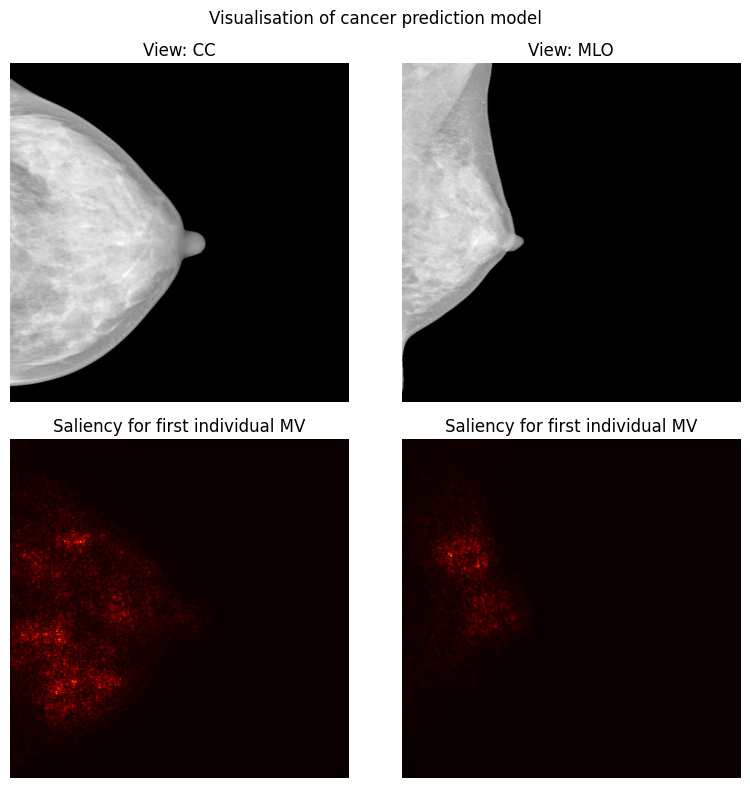

[array([[2.0559495e-02, 4.1912198e-02, 2.0030903e-02, ..., 3.5088425e-04,
         6.4984364e-05, 1.4631543e-04],
        [3.5558358e-02, 5.3145468e-02, 5.6627750e-02, ..., 2.5794268e-04,
         3.6594830e-04, 3.8814620e-04],
        [3.1399872e-02, 7.2600052e-02, 1.0036417e-01, ..., 8.1498141e-04,
         9.3532482e-04, 1.4126668e-03],
        ...,
        [7.2391592e-03, 2.2219917e-02, 1.5613400e-02, ..., 4.6708071e-04,
         5.1314710e-04, 5.4045988e-04],
        [9.3766432e-03, 1.5325690e-02, 1.9816924e-02, ..., 7.6313555e-04,
         1.1371337e-03, 6.9636042e-04],
        [4.1639481e-02, 2.8086334e-02, 2.5143096e-02, ..., 7.8930380e-04,
         8.0279226e-04, 7.2812132e-04]], dtype=float32),
 array([[0.01985343, 0.02781957, 0.0116538 , ..., 0.0004769 , 0.00060452,
         0.00042244],
        [0.00608317, 0.02424717, 0.01126891, ..., 0.00064733, 0.00087632,
         0.00068391],
        [0.01282555, 0.02646143, 0.01282872, ..., 0.00093371, 0.00083439,
         0.00112485]

In [83]:

sample_idx = 1964
sample_idx = 1
images_for_saliency, y1_label, y2_label = breast_loader.test_dataset[sample_idx] 

ajive_saliency_map(model, images_for_saliency, first_common_loading, plot=True, title = "Saliency for first common MV")

ajive_saliency_map(model, images_for_saliency, first_indiv_loading, plot=True, title = "Saliency for first individual MV")
